In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf

In [2]:
# define starting and ending point of data
start = '2010-01-01'
end = '2019-12-31'

# scrape data from yahoo finance
df = yf.download('AAPL', start=start, end=end)
df.head()

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,7.622500,7.660714,7.585000,7.643214,6.454506,493729600
2010-01-05,7.664286,7.699643,7.616071,7.656429,6.465665,601904800
2010-01-06,7.656429,7.686786,7.526786,7.534643,6.362820,552160000
2010-01-07,7.562500,7.571429,7.466071,7.520714,6.351058,477131200
2010-01-08,7.510714,7.571429,7.466429,7.570714,6.393279,447610800


In [3]:
df.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-12-23,70.132500,71.062500,70.092499,71.000000,68.908981,98572000
2019-12-24,71.172501,71.222504,70.730003,71.067497,68.974495,48478800
2019-12-26,71.205002,72.495003,71.175003,72.477501,70.342979,93121200
2019-12-27,72.779999,73.492500,72.029999,72.449997,70.316292,146266000
2019-12-30,72.364998,73.172501,71.305000,72.879997,70.733627,144114400


In [4]:
# remove date as index
df = df.reset_index()
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-01-04,7.622500,7.660714,7.585000,7.643214,6.454506,493729600
1,2010-01-05,7.664286,7.699643,7.616071,7.656429,6.465665,601904800
2,2010-01-06,7.656429,7.686786,7.526786,7.534643,6.362820,552160000
3,2010-01-07,7.562500,7.571429,7.466071,7.520714,6.351058,477131200
4,2010-01-08,7.510714,7.571429,7.466429,7.570714,6.393279,447610800


In [5]:
# drop columns that are not needed
df = df.drop(['Date', 'Adj Close'], axis=1)
df.head()

,Open,High,Low,Close,Volume
0,7.622500,7.660714,7.585000,7.643214,493729600
1,7.664286,7.699643,7.616071,7.656429,601904800
2,7.656429,7.686786,7.526786,7.534643,552160000
3,7.562500,7.571429,7.466071,7.520714,477131200
4,7.510714,7.571429,7.466429,7.570714,447610800


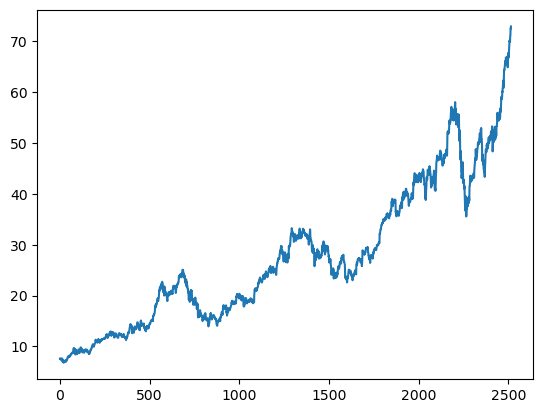

In [6]:
# plot close, label
plt.plot(df.Close)

In [7]:
# moving average for 100 days (average closing price across 100 days)
ma100 = df.Close.rolling(100).mean()
ma100

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
2510    59.201075
2511    59.401700
2512    59.643125
2513    59.875125
2514    60.106325
Name: Close, Length: 2515, dtype: float64

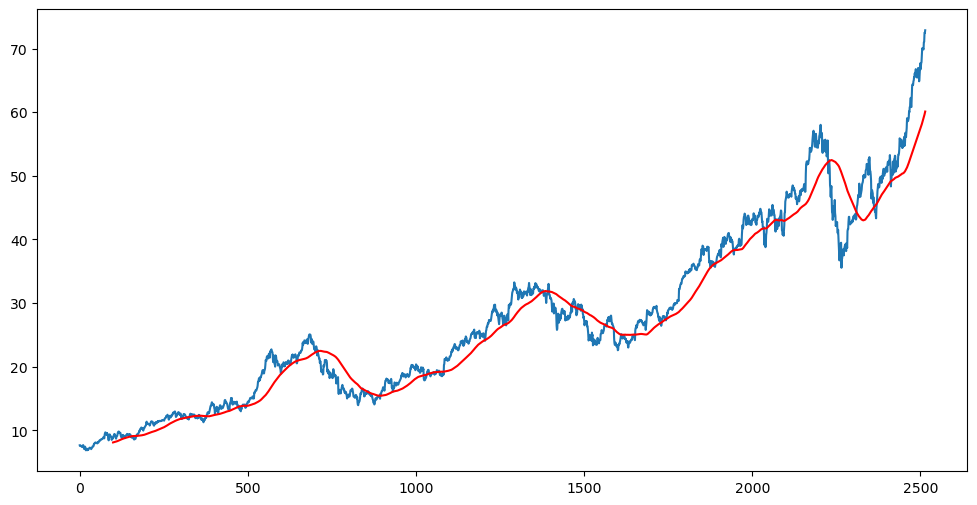

In [8]:
# plot closing price with 100 days moving average
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')

In [9]:
# moving average for 200 days (average closing price across 200 days)
ma200 = df.Close.rolling(200).mean()
ma200

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
          ...    
2510    54.132313
2511    54.261513
2512    54.396763
2513    54.529350
2514    54.661100
Name: Close, Length: 2515, dtype: float64

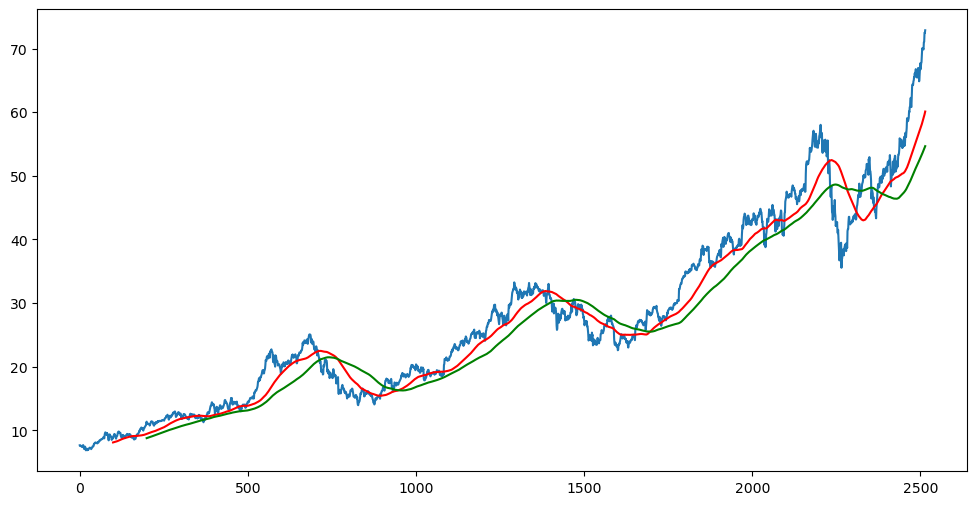

In [10]:
# plot closing price with 100 days moving average and 200 days moving average
plt.figure(figsize = (12,6))
plt.plot(df.Close)
plt.plot(ma100, 'r')
plt.plot(ma200, 'g')

In [11]:
df.shape

(2515, 5)

In [12]:
# split data into training and test (70% in training, 30% in testing)

data_training = pd.DataFrame(df['Close'][0:int(len(df)*0.70)])
data_test = pd.DataFrame(df['Close'][int(len(df)*0.70):int(len(df))])

print(data_training.shape)
print(data_test.shape)

(1760, 1)
(755, 1)


In [13]:
data_training.head()

,Close
0,7.643214
1,7.656429
2,7.534643
3,7.520714
4,7.570714


In [14]:
data_test.head()

,Close
1760,29.182501
1761,28.955000
1762,29.037500
1763,29.004999
1764,29.152500


In [15]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))

In [16]:
# scale data down to (0,1) for LSTM model training
data_training_arr = scaler.fit_transform(data_training)
data_training_arr

array([[0.02971782],
       [0.03021854],
       [0.02560389],
       ...,
       [0.84388656],
       [0.85089656],
       [0.84616011]])

In [17]:
data_training_arr.shape

(1760, 1)

In [18]:
# split data into x_train and y_train based on time series analysis 
# value for a particular day is dependent on previous days values 
x_train = [] # previous days
y_train = [] # predicted day

for i in range(100, data_training_arr.shape[0]): # value for 101th day depends on previous 100 days
    x_train.append(data_training_arr[i-100: i])
    y_train.append(data_training_arr[i, 0])

x_train, y_train = np.array(x_train), np.array(y_train) 

In [19]:
x_train.shape

(1660, 100, 1)

In [20]:
# ML model

from keras.layers import Input, Dense, Dropout, LSTM
from keras.models import Sequential

In [21]:
# LSTM model with 4 layers

model = Sequential()
model.add(Input(shape=(x_train.shape[1], 1)))

model.add(LSTM(units = 50, activation = 'relu', return_sequences = True))
model.add(Dropout(0.2))   

model.add(LSTM(units = 60, activation = 'relu', return_sequences = True))
model.add(Dropout(0.3))  

model.add(LSTM(units = 80, activation = 'relu', return_sequences = True))
model.add(Dropout(0.4))  

model.add(LSTM(units = 120, activation = 'relu'))
model.add(Dropout(0.5))  

model.add(Dense(units = 1))

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100, 50)        │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100, 50)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 100, 60)        │        26,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 100, 60)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 100, 80)        │        45,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100, 80)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 120)            │        96,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 120)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           121 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 178,761 (698.29 KB)

 Trainable params: 178,761 (698.29 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(x_train, y_train, epochs=50)

Epoch 1/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 7s 104ms/step - loss: 0.1229
Epoch 2/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0116
Epoch 3/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - loss: 0.0112
Epoch 4/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0092
Epoch 5/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 109ms/step - loss: 0.0080
Epoch 6/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0082
Epoch 7/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0076
Epoch 8/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0083
Epoch 9/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0064
Epoch 10/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - loss: 0.0071
Epoch 11/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0079
Epoch 12/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0065
Epoch 13/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - loss: 0.0065
Epoch 14/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - loss: 0.0063
Epoch 15/50
52/52 ━━━━━━━━━━━━━━━━━━━━ 6s 108ms/step - lo

In [24]:
model.save('stock_prediction_model.keras')

In [25]:
data_test.head()

,Close
1760,29.182501
1761,28.955000
1762,29.037500
1763,29.004999
1764,29.152500


In [26]:
# predict values of test data
past_100_days = data_training.tail(100)

In [27]:
final_df = pd.concat([past_100_days, data_test], ignore_index=True)

In [28]:
final_df.head()

,Close
0,27.092501
1,27.202499
2,27.000000
3,26.982500
4,27.045000


In [29]:
# scale down data to (0.1)
input_data = scaler.fit_transform(final_df)
input_data

array([[0.02781467],
       [0.03015022],
       [0.02585064],
       [0.02547908],
       [0.02680611],
       [0.03370671],
       [0.03317586],
       [0.03232658],
       [0.03158344],
       [0.03306972],
       [0.02855781],
       [0.03036255],
       [0.02600988],
       [0.02356814],
       [0.02022403],
       [0.01958704],
       [0.01523437],
       [0.01576518],
       [0.01910933],
       [0.02441747],
       [0.02425819],
       [0.02776158],
       [0.01268645],
       [0.        ],
       [0.01226183],
       [0.02558522],
       [0.04586231],
       [0.06603324],
       [0.06258295],
       [0.05547006],
       [0.05541697],
       [0.05531082],
       [0.06099053],
       [0.05085197],
       [0.05175434],
       [0.05286905],
       [0.05743405],
       [0.04803866],
       [0.05265676],
       [0.04984341],
       [0.05239133],
       [0.05265676],
       [0.05711557],
       [0.05801795],
       [0.06858117],
       [0.0699082 ],
       [0.07542863],
       [0.073

In [30]:
input_data.shape

(855, 1)

In [31]:
# split data for testing 
x_test = []
y_test = []

for i in range(100, input_data.shape[0]):
    x_test.append(input_data[i-100: i])
    y_test.append(input_data[i, 0])

In [32]:
x_test, y_test = np.array(x_test), np.array(y_test)
print(x_test.shape)
print(y_test.shape)

(755, 100, 1)
(755,)


In [33]:
# make predictions
y_predicted = model.predict(x_test)

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


In [34]:
y_predicted.shape

(755, 1)

In [35]:
y_test

array([0.0721907 , 0.06736028, 0.06911197, 0.06842189, 0.07155371,
       0.07845431, 0.08418707, 0.08482406, 0.08822126, 0.08556719,
       0.08445249, 0.0895483 , 0.0894952 , 0.0883805 , 0.0895483 ,
       0.08997296, 0.08938906, 0.09952758, 0.0998461 , 0.09989915,
       0.09820055, 0.09671427, 0.1359945 , 0.1348267 , 0.1377462 ,
       0.144169  , 0.15075112, 0.15345824, 0.15547536, 0.1538829 ,
       0.16009341, 0.16927655, 0.17187748, 0.17102824, 0.17299223,
       0.17819418, 0.18037053, 0.1772918 , 0.17798189, 0.17941503,
       0.17973358, 0.1945963 , 0.19019062, 0.19454325, 0.19220766,
       0.19316316, 0.19040291, 0.18870427, 0.19114605, 0.19146452,
       0.19034986, 0.19815283, 0.19937368, 0.195658  , 0.20346096,
       0.19486173, 0.20324859, 0.20059453, 0.19910825, 0.20038224,
       0.21588199, 0.21758055, 0.21657199, 0.21513885, 0.21535114,
       0.22103089, 0.21704978, 0.21513885, 0.21344021, 0.21253783,
       0.20436334, 0.20526571, 0.20128461, 0.20542495, 0.20208

In [36]:
y_predicted

array([[0.13426131],
       [0.13496695],
       [0.13560146],
       [0.13614064],
       [0.1365687 ],
       [0.13688071],
       [0.13709094],
       [0.13723424],
       [0.1373524 ],
       [0.13748649],
       [0.13766637],
       [0.13790326],
       [0.13819788],
       [0.1385524 ],
       [0.1389634 ],
       [0.13942048],
       [0.13991031],
       [0.14041618],
       [0.14093663],
       [0.14148325],
       [0.1420636 ],
       [0.14267543],
       [0.1433049 ],
       [0.14400816],
       [0.14488536],
       [0.14601958],
       [0.14747694],
       [0.14930782],
       [0.15153874],
       [0.15415518],
       [0.15697642],
       [0.16000156],
       [0.16322029],
       [0.16661245],
       [0.17013879],
       [0.17374757],
       [0.17738798],
       [0.18100616],
       [0.18454258],
       [0.18793932],
       [0.19114748],
       [0.19412887],
       [0.19688052],
       [0.19941051],
       [0.20173681],
       [0.20387551],
       [0.20584038],
       [0.207

In [37]:
scaler.scale_

array([0.02123255])

In [38]:
scale_factor = 1/0.02123255
y_predicted = y_predicted * scale_factor
y_test = y_test * scale_factor

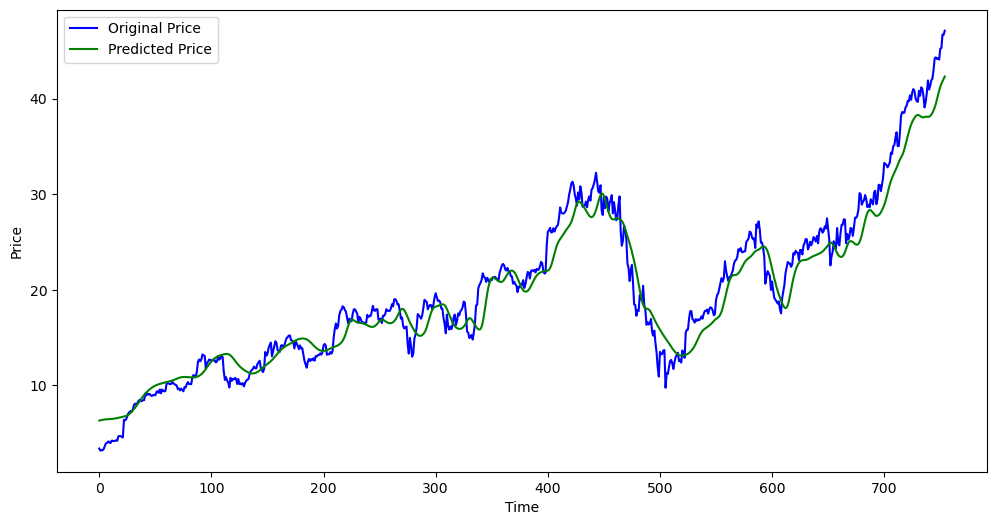

In [39]:
plt.figure(figsize=(12,6))
plt.plot(y_test, 'b', label = 'Original Price')
plt.plot(y_predicted, 'g', label = 'Predicted Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()